In [0]:
!apt install tree
!pip install pytorch-lightning
# !pip install tensorboardX

In [0]:
from google.colab import drive
drive.mount('/gdrive')

## Data loading 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/gdrive/My Drive/DL test/train.csv')

df = df.astype('float32')

y = df['y']
df.drop(columns=['y'], inplace=True)

We have deal with unbalanced dataset:

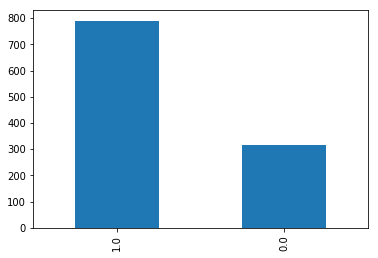

In [2]:
y.value_counts().plot(kind='bar');

One way to deal with it: assign class weights

In [0]:
from sklearn.utils import class_weight
class_weights = np.array(class_weight.compute_class_weight('balanced', np.unique(y), y))

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.3)

input_size = X_train.shape[1]

In [0]:
from torch.utils.data.dataset import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return (self.X[index], self.y[index])

    def __len__(self):
        return len(self.X)

## Utils

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Lets create a class that would implement Deep Feature Selection

In [0]:
class DFS(nn.Module):
  def __init__(self, input_size):
    super(DFS, self).__init__()
    weights = torch.randn(input_size)
    self.weight = nn.Parameter(weights)
  
  def forward(self, x):
    return self.weight * x.type_as(self.weight)

Lets create loss custom loss function. Also we add a class weights for case where we have imbalanced dataset

In [0]:
class MyCustomLoss(nn.Module):
  def __init__(self, model, lambda1, lambda2, alpha1, alpha2, class_weights=None):
    super().__init__()
    self.model = model
    self.lambda1 = lambda1
    self.lambda2 = lambda2
    self.alpha1 = alpha1
    self.alpha2 = alpha2
    self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    
  def forward(self, output, target):
    """
    This function make assumption that model[1] is DFS layer, and models[0] is Sequential
    """
    target = target.view(-1,1)
    standard_loss = nn.BCELoss(weight=self.class_weights[target.type(torch.LongTensor)])
    loss = standard_loss(output, target)
    
    modules = self.model.modules()
    
    #ignore sequential
    next(modules)
    
    #dfs loss
    dfs = next(modules)
    dfs_weights = dfs.weight
    
    loss += self.lambda1 * ((1 - self.lambda2) / 2 * (dfs_weights.norm(p=2) ** 2) +
                            self.lambda2 * dfs_weights.abs().sum())
    
    #elastic-net-like for other layers
    for module in modules:
      if not hasattr(module, 'weight'):
        continue
      loss += self.alpha1 * ((1 - self.alpha2) / 2 * (module.weight.norm(p=2) ** 2) +
                             self.alpha2 * module.weight.abs().sum())
    self.loss = loss
    return loss  

We need somehow evaluate our model. We can use metrics from sklearn, but this metrics for batch somewhat misleading. But if we evaluate on all validation data, we derive result that likely to be the truth

In [0]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score

class Metric:
  def __init__(self, name, function):
    self.name = name
    self.function = function
    
  def return_as_dict(self, value):
    return {self.name: value}
  
  def calc(self, output: torch.Tensor, target: torch.Tensor):
    return self.return_as_dict(torch.tensor([self.function(target.detach().cpu(), 
                                                           output.detach().cpu())]))
  

class ThresholdMetric(Metric):
  def __init__(self, *args, threshold=0.5):
    super().__init__(*args)
    self.set_threshold(threshold)
  
  def set_threshold(self, threshold):
    self.threshold = threshold
    
  def calc(self, output: torch.Tensor, target: torch.Tensor):
    predicted_classes = output.gt(self.threshold).type(torch.LongTensor)
    return super().calc(predicted_classes, target)

  
class Metrics:
  def __init__(self, name, threshold=0.5):
    
    self.metrics = [
        ThresholdMetric(name+'_precision', precision_score, threshold=threshold),
        ThresholdMetric(name+'_recall', recall_score, threshold=threshold),
        ThresholdMetric(name+'_accuracy', accuracy_score, threshold=threshold),
        Metric(name+'_roc_auc', roc_auc_score),
        Metric(name+'_AP', average_precision_score)
    ]
  
  def calc(self, output, target):
    result = list(map(lambda el: el.calc(output, target), self.metrics))
    return {k: v for d in result for k, v in d.items()}

## Train nn

In [0]:
loss_attrs = {
    'alpha1': 0.01,
    'alpha2': 0.01,
    'lambda1': 0.01,
    'lambda2': 0.01,
}

For convenient training our model I'll use [pytorch-lightning](https://github.com/williamFalcon/pytorch-lightning). It is a very lightweight wrapper on PyTorch and controls some things for you. And with this you can fastly build and train model. It also saves all metrics and loss in TensorBoard format.

In [0]:
from torch.utils.data import DataLoader

class CoolSystem(pl.LightningModule):
  def __init__(self, loss_attrs, class_weights):
    super().__init__()
    
    self.model = nn.Sequential(
        DFS(input_size),
        nn.Linear(input_size, 100),
        nn.Linear(100, 1),
        nn.Sigmoid()
    )
    
    self.loss = MyCustomLoss(self.model, **loss_attrs, class_weights=class_weights)
    self.train_metrics = Metrics('train')
    self.val_metrics = Metrics('val')
  
  def forward(self, x):
    return self.model(x)
    
  def training_step(self, batch, batch_nb):
    x, y = batch
    y_hat = self.forward(x)
    return dict(loss=self.loss(y_hat, y), **self.train_metrics.calc(y_hat, y))
    
  def validation_step(self, batch, batch_nb):
    x, y = batch
    y_hat = self.forward(x)
    return dict(val_loss=self.loss(y_hat, y), **self.val_metrics.calc(y_hat, y))
  
  def validation_end(self, outputs):
    # OPTIONAL
    print([dic['val_precision'] for dic in outputs])
    v = {'avg_'+k: torch.stack([dic[k] for dic in outputs]).mean() for k in outputs[0]}
    return v
  
  def configure_optimizers(self):
    # REQUIRED
    # can return multiple optimizers and learning_rate schedulers
    return optim.Adam(self.model.parameters(), lr=1e-3)
  
  @pl.data_loader
  def tng_dataloader(self):
      # REQUIRED
      return DataLoader(MyCustomDataset(X_train, y_train), batch_size=32)

  @pl.data_loader
  def val_dataloader(self):
      # OPTIONAL
      return DataLoader(MyCustomDataset(X_test, y_test), batch_size=32)


In [19]:
from pytorch_lightning import Trainer
from test_tube import Experiment
import os

model = CoolSystem(loss_attrs=loss_attrs, class_weights=class_weights)

# PyTorch summarywriter with a few bells and whistles    
exp = Experiment(save_dir=os.getcwd())

# train on cpu using only 10% of the data (for demo purposes)
# pass in experiment for automatic tensorboard logging.    
trainer = Trainer(experiment=exp, max_nb_epochs=20, gpus=[0])

  
trainer.fit(model)

 17%|█▋        | 6/36 [00:00<00:01, 18.42it/s, batch_nb=5, epoch=0, gpu=0, tng_loss=8.188, v_nb=21]

VISIBLE GPUS: '0'
gpu available: True, used: True
      Name          Type  Params
0    model    Sequential  154125
1  model.0           DFS    1524
2  model.1        Linear  152500
3  model.2        Linear     101
4  model.3       Sigmoid       0
5     loss  MyCustomLoss  154125
[tensor([0.5556]), tensor([0.6667]), tensor([0.6000]), tensor([0.3333]), tensor([0.5714])]


 17%|█▋        | 6/36 [00:00<00:01, 17.76it/s, avg_valAP=0.948, avg_val_accuracy=0.745, avg_val_loss=7.65, avg_val_precision=0.925, avg_val_recall=0.702, avg_val_roc_auc=0.882, batch_nb=5, epoch=1, gpu=0, tng_loss=7.873, v_nb=21]

[tensor([1.]), tensor([0.9444]), tensor([0.9000]), tensor([1.]), tensor([0.8125]), tensor([0.8000]), tensor([0.9375]), tensor([1.]), tensor([1.]), tensor([0.7826]), tensor([1.])]


 14%|█▍        | 5/36 [00:00<00:02, 15.45it/s, avg_valAP=0.971, avg_val_accuracy=0.824, avg_val_loss=7.23, avg_val_precision=0.958, avg_val_recall=0.789, avg_val_roc_auc=0.929, batch_nb=4, epoch=2, gpu=0, tng_loss=7.624, v_nb=21]

[tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([0.8889]), tensor([1.]), tensor([0.8824]), tensor([0.9474]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 14%|█▍        | 5/36 [00:00<00:01, 15.56it/s, avg_valAP=0.977, avg_val_accuracy=0.835, avg_val_loss=6.91, avg_val_precision=0.968, avg_val_recall=0.797, avg_val_roc_auc=0.944, batch_nb=4, epoch=3, gpu=0, tng_loss=7.422, v_nb=21]

[tensor([1.]), tensor([1.]), tensor([0.9565]), tensor([0.8947]), tensor([1.]), tensor([0.8824]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 17%|█▋        | 6/36 [00:00<00:01, 16.83it/s, avg_valAP=0.977, avg_val_accuracy=0.844, avg_val_loss=6.63, avg_val_precision=0.973, avg_val_recall=0.806, avg_val_roc_auc=0.945, batch_nb=5, epoch=4, gpu=0, tng_loss=7.180, v_nb=21]

[tensor([1.]), tensor([1.]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 17%|█▋        | 6/36 [00:00<00:01, 17.31it/s, avg_valAP=0.976, avg_val_accuracy=0.844, avg_val_loss=6.36, avg_val_precision=0.968, avg_val_recall=0.81, avg_val_roc_auc=0.945, batch_nb=5, epoch=5, gpu=0, tng_loss=6.825, v_nb=21]

[tensor([1.]), tensor([0.9545]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 17%|█▋        | 6/36 [00:00<00:01, 17.30it/s, avg_valAP=0.977, avg_val_accuracy=0.852, avg_val_loss=6.11, avg_val_precision=0.968, avg_val_recall=0.822, avg_val_roc_auc=0.946, batch_nb=5, epoch=6, gpu=0, tng_loss=6.530, v_nb=21]

[tensor([1.]), tensor([0.9545]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 18.03it/s, avg_valAP=0.977, avg_val_accuracy=0.852, avg_val_loss=5.88, avg_val_precision=0.968, avg_val_recall=0.822, avg_val_roc_auc=0.946, batch_nb=6, epoch=7, gpu=0, tng_loss=6.248, v_nb=21]

[tensor([1.]), tensor([0.9545]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 18.25it/s, avg_valAP=0.977, avg_val_accuracy=0.849, avg_val_loss=5.65, avg_val_precision=0.963, avg_val_recall=0.822, avg_val_roc_auc=0.946, batch_nb=6, epoch=8, gpu=0, tng_loss=5.997, v_nb=21]

[tensor([1.]), tensor([0.9545]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([0.9444]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 17.97it/s, avg_valAP=0.977, avg_val_accuracy=0.855, avg_val_loss=5.44, avg_val_precision=0.963, avg_val_recall=0.83, avg_val_roc_auc=0.946, batch_nb=6, epoch=9, gpu=0, tng_loss=5.760, v_nb=21]

[tensor([1.]), tensor([0.9545]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([0.9444]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 17%|█▋        | 6/36 [00:00<00:01, 17.85it/s, avg_valAP=0.976, avg_val_accuracy=0.86, avg_val_loss=5.24, avg_val_precision=0.955, avg_val_recall=0.844, avg_val_roc_auc=0.944, batch_nb=5, epoch=10, gpu=0, tng_loss=5.544, v_nb=21]

[tensor([1.]), tensor([0.9130]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([0.8947]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 18.01it/s, avg_valAP=0.974, avg_val_accuracy=0.86, avg_val_loss=5.05, avg_val_precision=0.955, avg_val_recall=0.844, avg_val_roc_auc=0.941, batch_nb=6, epoch=11, gpu=0, tng_loss=5.323, v_nb=21]

[tensor([1.]), tensor([0.9130]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([0.8947]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 18.12it/s, avg_valAP=0.974, avg_val_accuracy=0.86, avg_val_loss=4.87, avg_val_precision=0.955, avg_val_recall=0.844, avg_val_roc_auc=0.942, batch_nb=6, epoch=12, gpu=0, tng_loss=5.120, v_nb=21]

[tensor([1.]), tensor([0.9130]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([0.8947]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 17.83it/s, avg_valAP=0.974, avg_val_accuracy=0.86, avg_val_loss=4.7, avg_val_precision=0.955, avg_val_recall=0.844, avg_val_roc_auc=0.94, batch_nb=6, epoch=13, gpu=0, tng_loss=4.928, v_nb=21]

[tensor([1.]), tensor([0.9130]), tensor([0.9565]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([0.8947]), tensor([1.]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 17.96it/s, avg_valAP=0.974, avg_val_accuracy=0.86, avg_val_loss=4.54, avg_val_precision=0.951, avg_val_recall=0.847, avg_val_roc_auc=0.94, batch_nb=6, epoch=14, gpu=0, tng_loss=4.744, v_nb=21]

[tensor([1.]), tensor([0.9130]), tensor([0.9583]), tensor([0.9444]), tensor([1.]), tensor([0.8889]), tensor([0.8947]), tensor([0.9500]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 17%|█▋        | 6/36 [00:00<00:01, 16.65it/s, avg_valAP=0.974, avg_val_accuracy=0.86, avg_val_loss=4.38, avg_val_precision=0.947, avg_val_recall=0.851, avg_val_roc_auc=0.94, batch_nb=5, epoch=15, gpu=0, tng_loss=4.576, v_nb=21]

[tensor([1.]), tensor([0.9167]), tensor([0.9583]), tensor([0.8947]), tensor([1.]), tensor([0.8889]), tensor([0.8947]), tensor([0.9500]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 18.83it/s, avg_valAP=0.974, avg_val_accuracy=0.868, avg_val_loss=4.23, avg_val_precision=0.952, avg_val_recall=0.86, avg_val_roc_auc=0.941, batch_nb=6, epoch=16, gpu=0, tng_loss=4.402, v_nb=21]

[tensor([1.]), tensor([0.9167]), tensor([0.9583]), tensor([0.8947]), tensor([1.]), tensor([0.8947]), tensor([0.9444]), tensor([0.9500]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 17.56it/s, avg_valAP=0.974, avg_val_accuracy=0.866, avg_val_loss=4.08, avg_val_precision=0.948, avg_val_recall=0.86, avg_val_roc_auc=0.94, batch_nb=6, epoch=17, gpu=0, tng_loss=4.243, v_nb=21]

[tensor([1.]), tensor([0.9167]), tensor([0.9583]), tensor([0.8947]), tensor([1.]), tensor([0.8947]), tensor([0.9444]), tensor([0.9048]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 18.27it/s, avg_valAP=0.973, avg_val_accuracy=0.868, avg_val_loss=3.94, avg_val_precision=0.948, avg_val_recall=0.864, avg_val_roc_auc=0.939, batch_nb=6, epoch=18, gpu=0, tng_loss=4.092, v_nb=21]

[tensor([1.]), tensor([0.9200]), tensor([0.9583]), tensor([0.8947]), tensor([1.]), tensor([0.8947]), tensor([0.9444]), tensor([0.9048]), tensor([1.]), tensor([0.9091]), tensor([1.])]


 19%|█▉        | 7/36 [00:00<00:01, 18.01it/s, avg_valAP=0.973, avg_val_accuracy=0.868, avg_val_loss=3.81, avg_val_precision=0.948, avg_val_recall=0.864, avg_val_roc_auc=0.938, batch_nb=6, epoch=19, gpu=0, tng_loss=3.948, v_nb=21]

[tensor([1.]), tensor([0.9200]), tensor([0.9583]), tensor([0.8947]), tensor([1.]), tensor([0.8947]), tensor([0.9444]), tensor([0.9048]), tensor([1.]), tensor([0.9091]), tensor([1.])]


100%|██████████| 36/36 [00:00<00:00, 26.83it/s, avg_valAP=0.973, avg_val_accuracy=0.868, avg_val_loss=3.68, avg_val_precision=0.948, avg_val_recall=0.864, avg_val_roc_auc=0.939, batch_nb=24, epoch=19, gpu=0, tng_loss=3.849, v_nb=21]

[tensor([1.]), tensor([0.9200]), tensor([0.9583]), tensor([0.8947]), tensor([1.]), tensor([0.8947]), tensor([0.9444]), tensor([0.9048]), tensor([1.]), tensor([0.9091]), tensor([1.])]


1

In [0]:
!rm -rf /gdrive/My\ Drive/TensorBoard
!cp -r default/ /gdrive/My\ Drive/TensorBoard

In [23]:
from pprint import pprint
predicted = model(torch.tensor(X_test))
pprint(Metrics('NN').calc(predicted, torch.tensor(y_test)))

{'NNAP': tensor([0.9507]),
 'NN_accuracy': tensor([0.8554]),
 'NN_precision': tensor([0.9469]),
 'NN_recall': tensor([0.8412]),
 'NN_roc_auc': tensor([0.9076])}


## RandomForests approach comparision

In [26]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)

CPU times: user 131 ms, sys: 10.2 ms, total: 141 ms
Wall time: 146 ms


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
predicted = rfc.predict(X_test)
pprint(Metrics('RF').calc(torch.tensor(predicted), torch.tensor(y_test)))

{'RFAP': tensor([0.8607]),
 'RF_accuracy': tensor([0.8524]),
 'RF_precision': tensor([0.8740]),
 'RF_recall': tensor([0.9227]),
 'RF_roc_auc': tensor([0.8048])}


Thus we can conclude, that in general Neural Network with DFS better than RandomForests, but worse only in recall